# CSE519 Project: Dating Documents
## Tim Zhang (110746199)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
from time import time
from IPython.display import display
from bs4 import BeautifulSoup
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

# Global settings
%matplotlib notebook
pd.set_option('display.max_rows', None)  

# Exploratory Analysis

## Corpus of Historical American English (COHA)
### Parsing

We will need to parse the COHA corpus into date labels and text.  The corpus is subdivided by sources as Fiction, Magazine, News, and Nonfiction.  It may prove useful to keep the categories of data sources disjoint.

The data files have an easily parsable format, where newlines delimit the examples $(x^{(i)}, y^{(i)})$ and the label is delimited with a tab.  We will store the data as a Pandas dataframe.

In [2]:
def parse_coha(filename):
    data = []
    
    with open('Data/COHA/' + filename, 'r') as f:
        samples = f.read().split('\n')[:-1]  # Ignore final newline
    
    for sample in samples:
        split = sample.split('\t')
        data.append((split[0], split[1]))

    # Save data into dataframe
    df = pd.DataFrame(data, columns=['Year', 'Text']).sort_values(['Year'])
    
    # Create Decade label
    df['Decade'] = df.apply(lambda row: int(str(row.Year)[:3] + '0'), axis=1)
    
    return df

Now we can parse each of the COHA categories into a dictionary.

In [3]:
sources = ['coha_fiction', 'coha_mag', 'coha_news', 'coha_nf']
coha_data = dict.fromkeys(sources, pd.DataFrame)

for source in sources:
    coha_data[source] = parse_coha(source + '.data')

Next we will concatenate each dataframe into the full dataset and add a new column for the length of the text.

In [40]:
coha_full = coha_data['coha_mag'].append(coha_data['coha_news']).append(coha_data['coha_fiction']).append(coha_data['coha_nf'])
coha_full.sort_values(['Year'], inplace=True)
coha_full.reset_index(drop=True, inplace=True)
coha_full['Length'] = coha_full.apply(lambda row: len(row.Text.split()), axis=1)

Finally, we will save the dataframe as a pkl object.

In [59]:
coha_full.to_pickle('coha_full.pkl')

In [2]:
coha_full = pd.read_pickle('coha_full.pkl')

### Analysis

Once we have our data parsed into dataframes, we should do some exploratory analysis.  For this we will investigate summary statistics of the full dataset at the year and decade resolutions with respect to the occurances of the labels.  Since there are almost 200 years represented in the dataset, we will output this data raw.

In [3]:
def analyze_coverage(counts):
    # Print summary statistics on coverage data
    print("    Max: %s" % (counts.max()))
    print("    Min: %s" % (counts.min()))
    print("    Mean: %s" % (counts.mean()))
    print("    Std: %s" % (counts.std()))
    print("    Median: %s" % (counts.median()))

In [4]:
def analyze_corpus_data(df):
    # Get year coverage data
    counts = pd.value_counts(df['Year']).sort_index()
    
    print "Year Coverage Statistics:"
    analyze_coverage(counts)

    print '\nComplete Year Distribution:'
    print counts.head(-1)
    print '\n'
    
    # Get decade coverate data
    decade_counts = pd.value_counts(df['Decade']).sort_index()
    print "Decade Coverage Statistics:"
    analyze_coverage(decade_counts)

    plt.figure()
    decade_counts.sort_index().plot(kind='barh', title="Number of Documents per Decade")
    print '\n'

Year Coverage Statistics:
    Max: 1278
    Min: 1
    Mean: 200.0
    Std: 212.749740919
    Median: 130.0

Complete Year Distribution:
1810       2
1811       4
1812       6
1813       1
1814       3
1815      11
1816       8
1817       9
1818       5
1819       7
1820      14
1821      20
1822      21
1823      21
1824      16
1825      13
1826      16
1827      39
1828      27
1829      37
1830      40
1831      25
1832      44
1833      55
1834      50
1835      67
1836      63
1837      44
1838      39
1839      60
1840      30
1841      30
1842      34
1843      45
1844      76
1845      69
1846      45
1847      58
1848      52
1849      65
1850      40
1851      41
1852      44
1853      55
1854      43
1855      61
1856      45
1857      35
1858      18
1859      48
1860      30
1861      45
1862      56
1863      54
1864      90
1865      49
1866      47
1867      41
1868      76
1869      68
1870      39
1871      75
1872      59
1873      76
1874      89
1875      94
1876 

<IPython.core.display.Javascript object>


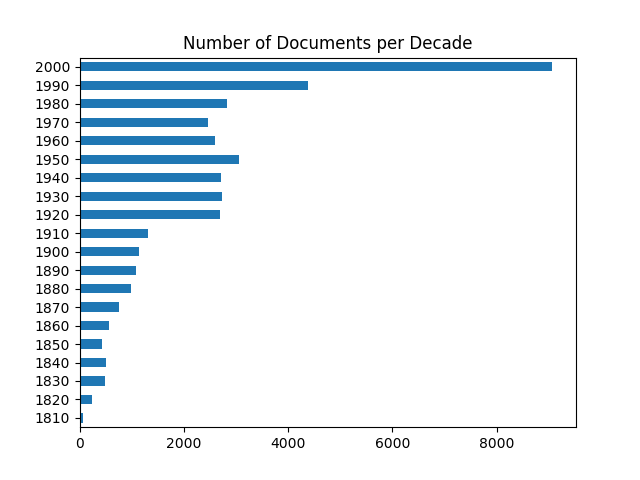

In [5]:
analyze_corpus_data(coha_full)

From the above analysis we see that the COHA dataset is not balanced with respect to year (or decade) representation.  As mentioned in my preliminary report, we should try to balance our classes for the best results.  As such we will need our other data sources to try and fill in the gaps.

Next let us investigate the size of the datasets (in tokens) at decade resolution.

In [5]:
def analyze_text(df):
    decades = df.groupby('Decade')['Length']
    print 'Text Frequency Statistics:'
    print("\nTotal:\n%s" % (decades.sum()))
    print("\nMax:\n%s" % (decades.max()))
    print("\nMin:\n%s" % (decades.min()))
    print("\nMean:\n%s" % (decades.mean()))
    print("\nStd:\n%s" % (decades.std()))
    print("\nMedian:\n%s" % (decades.median()))
    plt.figure()
    decades.sum().plot(kind='barh', title="Total Token Count per Decade")

Text Frequency Statistics:

Total:
Decade
1810     2866316
1820     9496850
1830    21853319
1840    23512631
1850    24376172
1860    19617488
1870    24253002
1880    25419490
1890    24617174
1900    26362711
1910    28253093
1920    25997854
1930    26737154
1940    25890449
1950    27062006
1960    25365215
1970    26211245
1980    30264682
1990    29758832
2000    30458993
Name: Length, dtype: int64

Max:
Decade
1810    227155
1820    160380
1830    252998
1840    364780
1850    251887
1860    255796
1870    213229
1880    191478
1890    200410
1900    240932
1910    210337
1920    213193
1930    245479
1940    213128
1950    207824
1960    176500
1970    302613
1980    294180
1990    141824
2000     60408
Name: Length, dtype: int64

Min:
Decade
1810    216
1820    197
1830    180
1840      1
1850      0
1860    188
1870      1
1880    152
1890     58
1900    149
1910    145
1920     43
1930     66
1940     33
1950     61
1960     60
1970     28
1980     14
1990      7
2000      

<IPython.core.display.Javascript object>


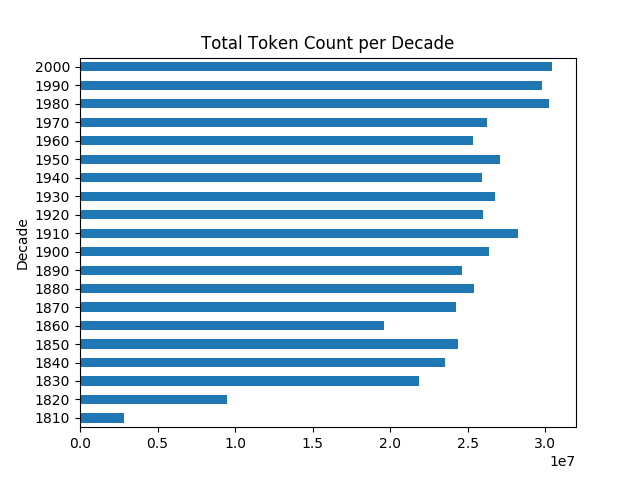

In [7]:
analyze_text(coha_full)

We can see that the amount of tokens per decade is relatively balanced.  This implies that while there are less documents for the earlier decades, each document has more text.  The summary statistics also indicate that this is the case.

# Evaluation Environment

First let us partition our training data into train and test splits, saving the results for convenience.

In [36]:
coha_train, coha_test = train_test_split(coha_full, test_size=0.2)
coha_train.to_pickle('coha_train.pkl')
coha_test.to_pickle('coha_test.pkl')

In [2]:
coha_train = pd.read_pickle('coha_train.pkl')
coha_test = pd.read_pickle('coha_test.pkl')

Next we will define our evaluation function which we will use to compare different models.

In [7]:
decades = [1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]

def eval_learner(y, pred):
    # Display confusion matrix
    df_cm = pd.DataFrame(confusion_matrix(y, pred), index = [i for i in decades], columns = [i for i in decades])
    plt.figure(figsize = (20,10))
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

    # Display metrics
    print(classification_report(y, pred, target_names=map(str, decades)))
    print('Accuracy: %s\n' % accuracy_score(y, pred))
    print('MAE: %s' % mean_absolute_error(y, pred))

## The Monkey

Next we will investigate how well the "monkey" does on our test set.

In [11]:
monkey_pred = [decades[i] for i in np.random.choice(20, len(coha_test))]

<IPython.core.display.Javascript object>


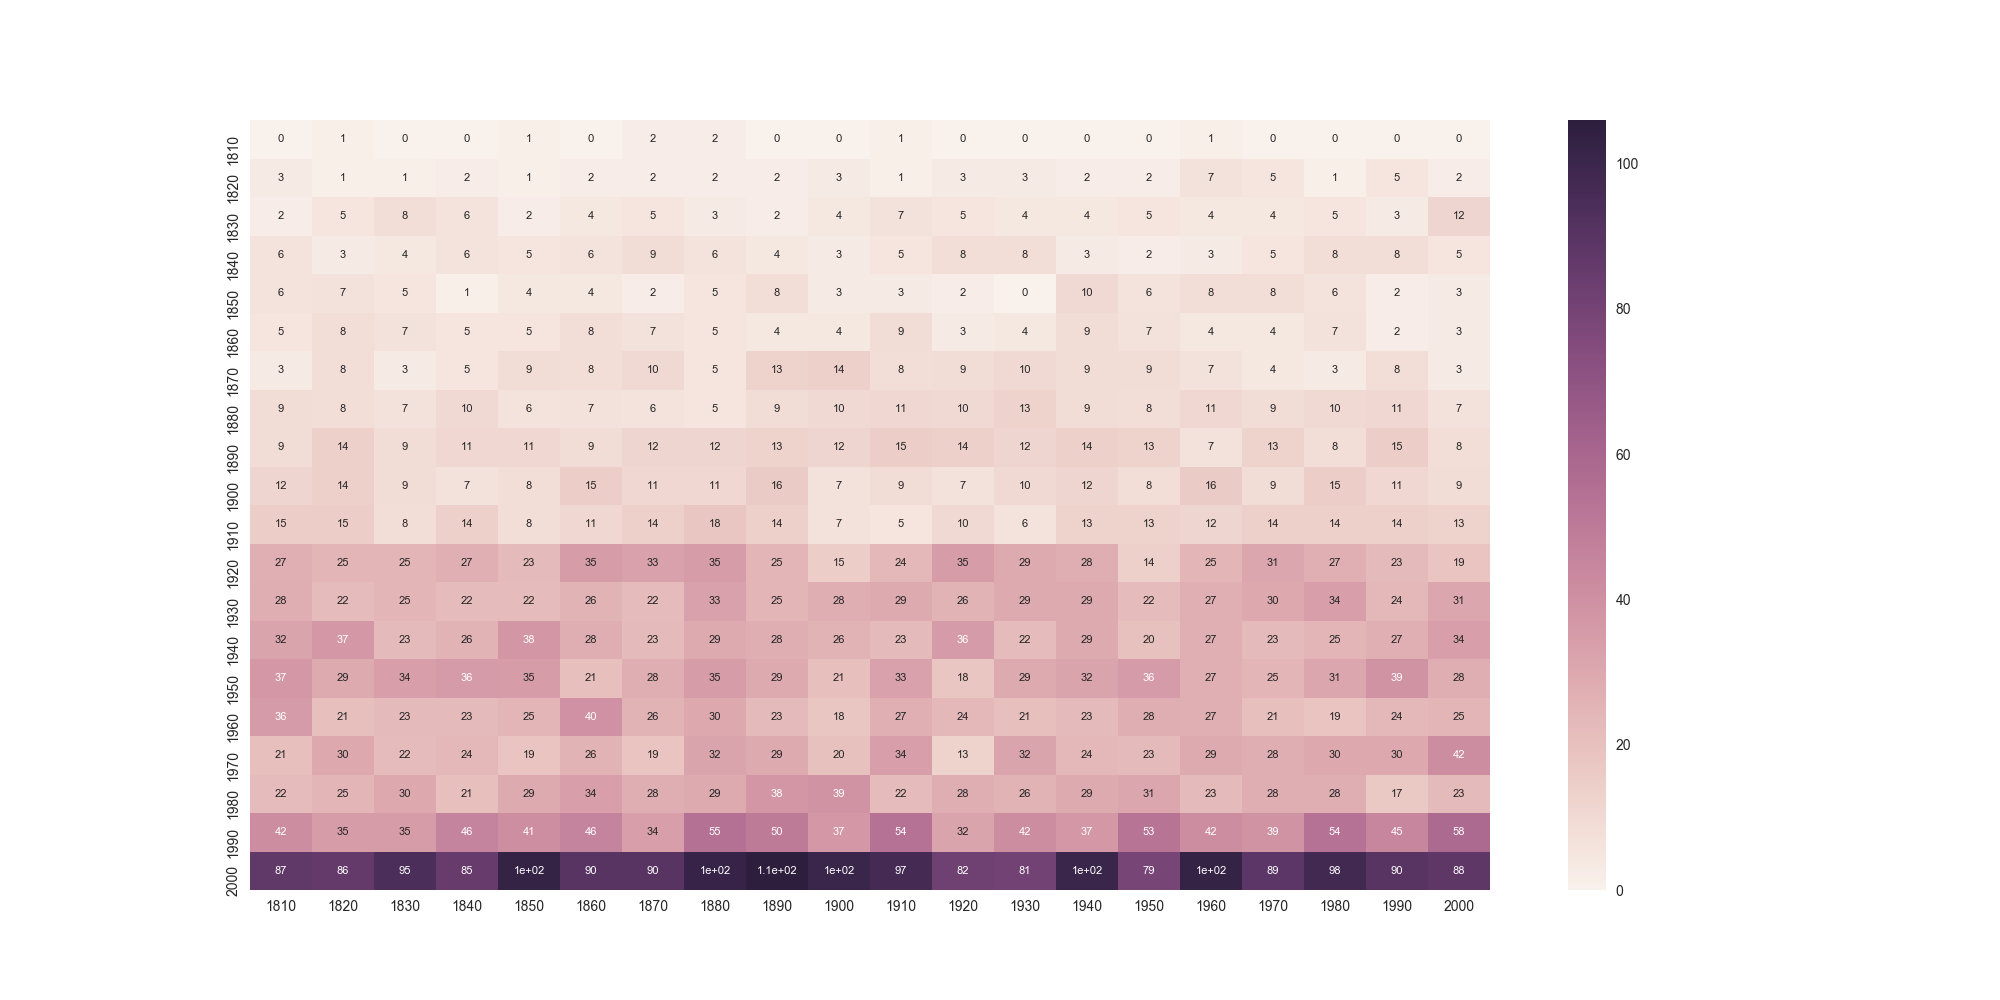

Accuracy: 0.0515

             precision    recall  f1-score   support

       1810       0.00      0.00      0.00         8
       1820       0.00      0.02      0.00        50
       1830       0.02      0.09      0.03        94
       1840       0.02      0.06      0.02       107
       1850       0.01      0.04      0.02        93
       1860       0.02      0.07      0.03       110
       1870       0.03      0.07      0.04       148
       1880       0.01      0.03      0.02       176
       1890       0.03      0.06      0.04       231
       1900       0.02      0.03      0.02       216
       1910       0.01      0.02      0.02       238
       1920       0.10      0.07      0.08       525
       1930       0.08      0.05      0.06       534
       1940       0.07      0.05      0.06       556
       1950       0.09      0.06      0.07       603
       1960       0.07      0.05      0.06       504
       1970       0.07      0.05      0.06       527
       1980       0.07     

In [30]:
eval_learner(coha_test['Decade'], monkey_pred)

We see that the test split has many more documents from 1990-2000 decades, which is unsurprising since the entire corpus follows this trend.  We also see that uniform choices will not lead to very high accuracy.

## Feature Extraction

For our learning algorithms we will need to process the raw text data into a numerical vector.  To achieve this we will use a Bag of Words model as a baseline.  We will later compare this naive approach to more sophisticated Bag of Ngrams.

In [5]:
vectorizer = CountVectorizer(stop_words='english')
transformer = TfidfTransformer()
X_train_counts = vectorizer.fit_transform(coha_train['Text'])
X_train = transformer.fit_transform(X_train_counts)

In [10]:
X_test_counts = vectorizer.transform(coha_test['Text'])
X_test = transformer.transform(X_test_counts)

Let's save our features for later use.

In [14]:
pickle.dump(X_train, open("coha_BoW_train.pkl", "wb"))
pickle.dump(X_test, open("coha_BoW_test.pkl", "wb"))

In [4]:
X_train = pickle.load(open("coha_BoW_train.pkl", "rb"))
X_test = pickle.load(open("coha_BoW_test.pkl", "rb"))

Next we will consider trigrams.

In [34]:
vectorizer_ng = HashingVectorizer(stop_words='english', ngram_range=(1, 3), non_negative=True)
transformer_ng = TfidfTransformer()
X_train_ngcounts = vectorizer_ng.transform(coha_train['Text'])
X_train_ng = transformer_ng.fit_transform(X_train_ngcounts)

1975.07061887


In [35]:
X_test_ngcounts = vectorizer_ng.transform(coha_test['Text'])
X_test_ng = transformer_ng.transform(X_test_ngcounts)

## Learning Algorithms

### Multinomial Naive Bayes

#### Unigram

In [24]:
MNB_clf = MultinomialNB().fit(X_train_counts, coha_train['Decade'])

In [25]:
MNB_pred = MNB_clf.predict(X_test_counts)

<IPython.core.display.Javascript object>


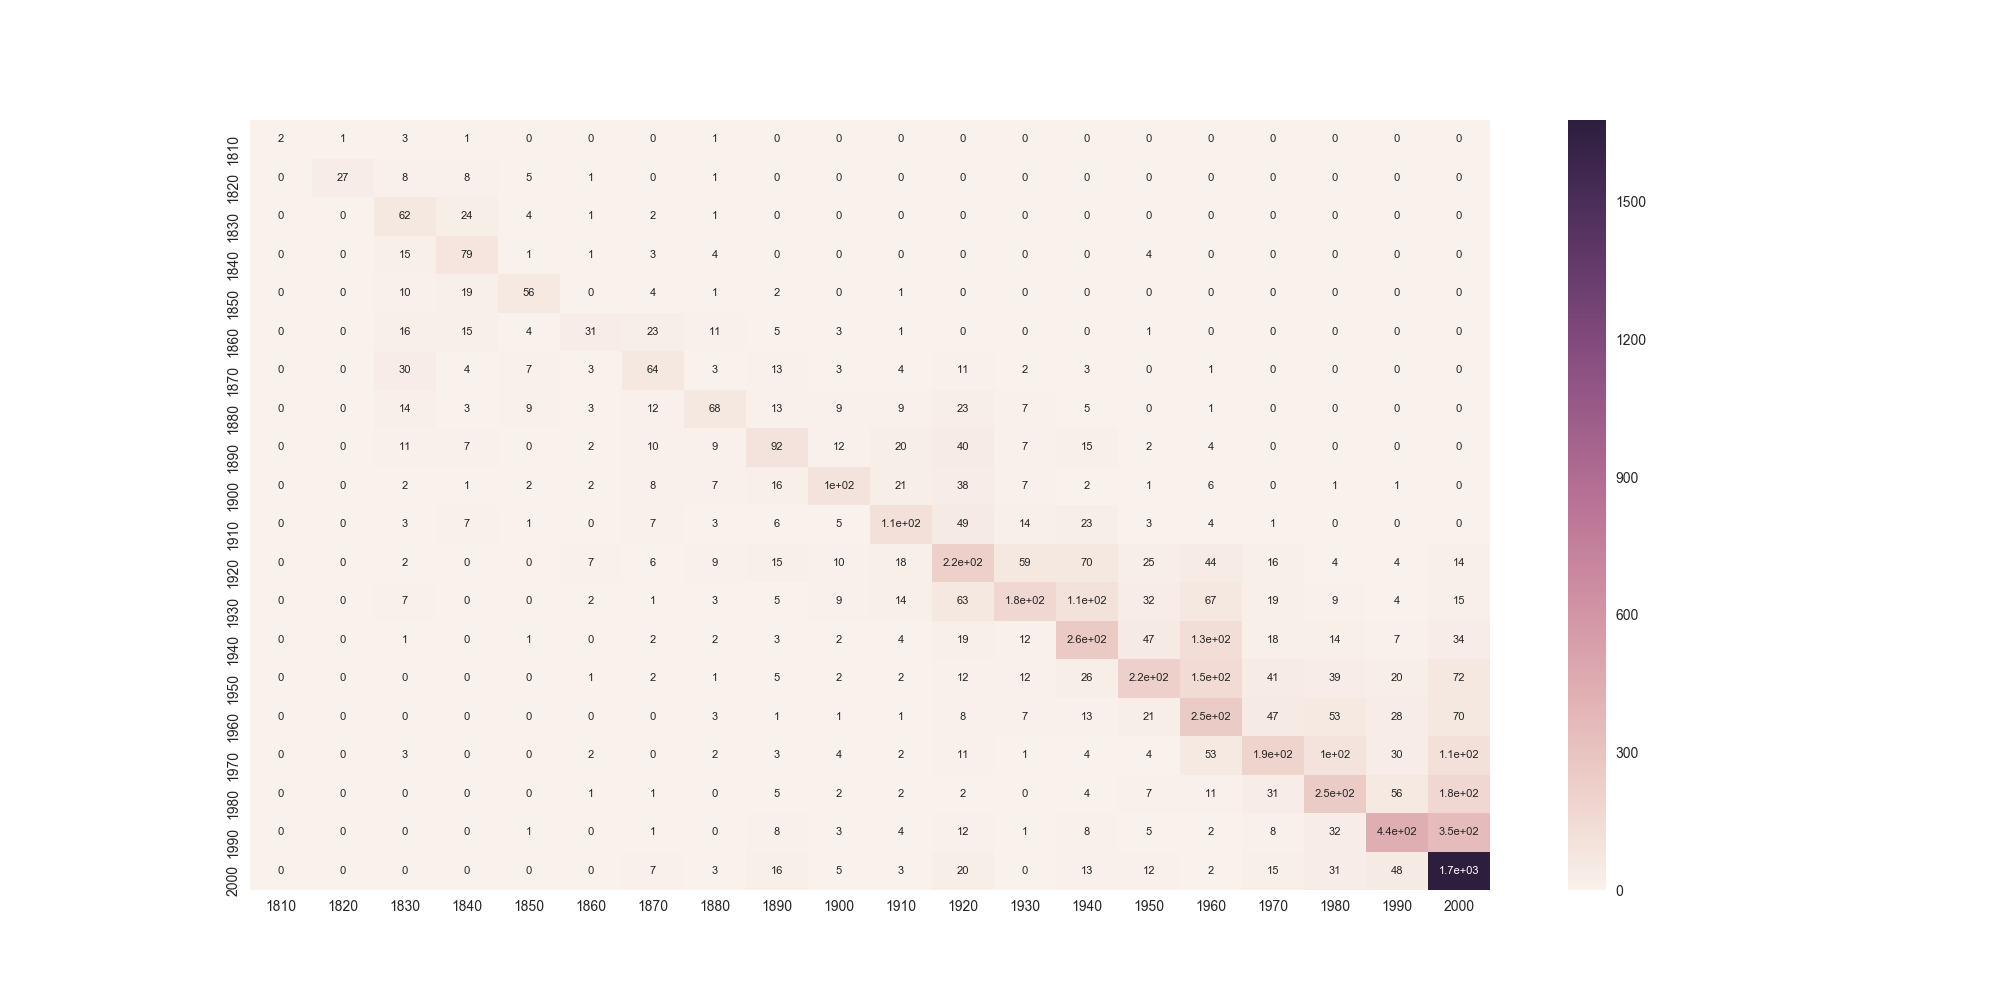

             precision    recall  f1-score   support

       1810       1.00      0.25      0.40         8
       1820       0.96      0.54      0.69        50
       1830       0.33      0.66      0.44        94
       1840       0.47      0.74      0.57       107
       1850       0.62      0.60      0.61        93
       1860       0.54      0.28      0.37       110
       1870       0.42      0.43      0.43       148
       1880       0.52      0.39      0.44       176
       1890       0.44      0.40      0.42       231
       1900       0.59      0.47      0.52       216
       1910       0.51      0.47      0.49       238
       1920       0.42      0.42      0.42       525
       1930       0.58      0.33      0.42       534
       1940       0.47      0.47      0.47       556
       1950       0.58      0.37      0.45       603
       1960       0.35      0.50      0.41       504
       1970       0.49      0.36      0.42       527
       1980       0.47      0.46      0.46   

In [26]:
eval_learner(coha_test['Decade'], MNB_pred)

#### Trigram

In [36]:
MNB_ngclf = MultinomialNB().fit(X_train_ngcounts, coha_train['Decade'])

In [37]:
MNB_ngpred = MNB_ngclf.predict(X_test_ngcounts)

<IPython.core.display.Javascript object>


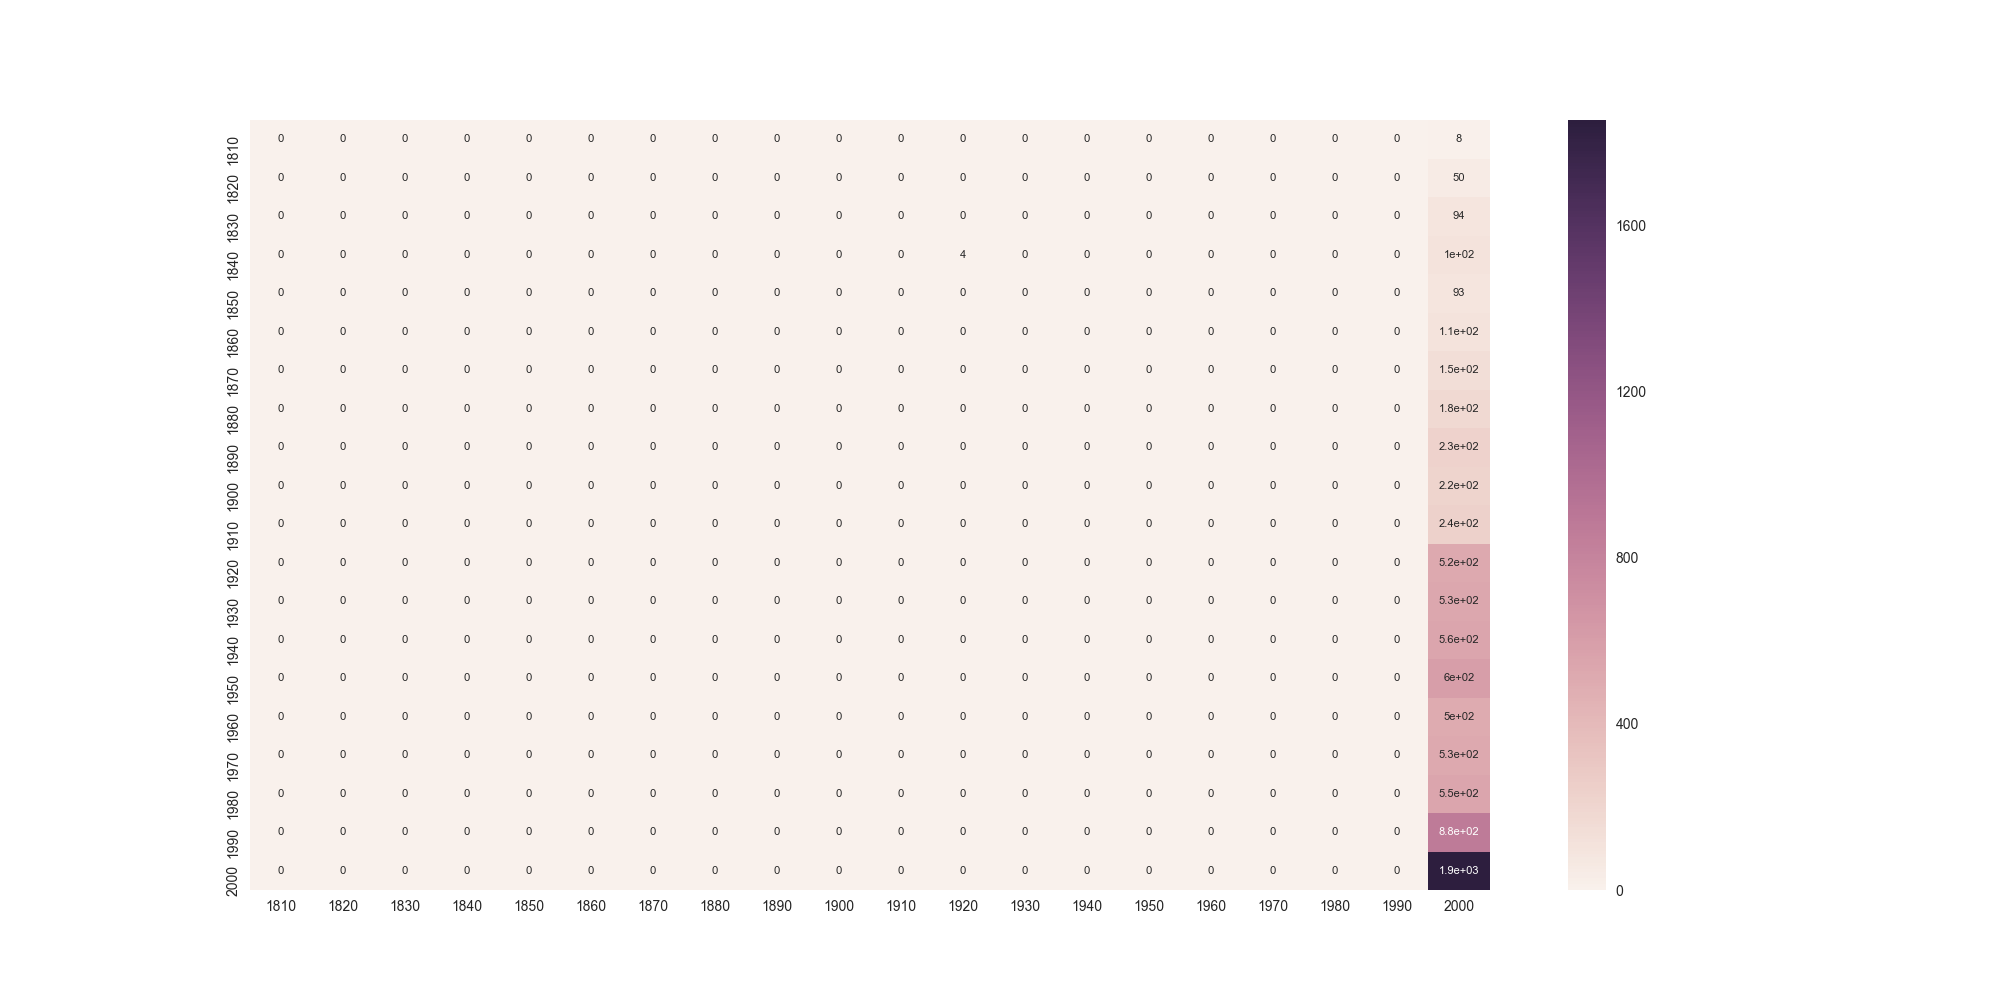

             precision    recall  f1-score   support

       1810       0.00      0.00      0.00         8
       1820       0.00      0.00      0.00        50
       1830       0.00      0.00      0.00        94
       1840       0.00      0.00      0.00       107
       1850       0.00      0.00      0.00        93
       1860       0.00      0.00      0.00       110
       1870       0.00      0.00      0.00       148
       1880       0.00      0.00      0.00       176
       1890       0.00      0.00      0.00       231
       1900       0.00      0.00      0.00       216
       1910       0.00      0.00      0.00       238
       1920       0.00      0.00      0.00       525
       1930       0.00      0.00      0.00       534
       1940       0.00      0.00      0.00       556
       1950       0.00      0.00      0.00       603
       1960       0.00      0.00      0.00       504
       1970       0.00      0.00      0.00       527
       1980       0.00      0.00      0.00   

/Users/heatherfrantz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
eval_learner(coha_test['Decade'], MNB_ngpred)

### Random Forest

#### Unigram

In [27]:
RF_clf = RandomForestClassifier(random_state=0).fit(X_train, coha_train['Decade'])

In [28]:
RF_pred = RF_clf.predict(X_test)

<IPython.core.display.Javascript object>


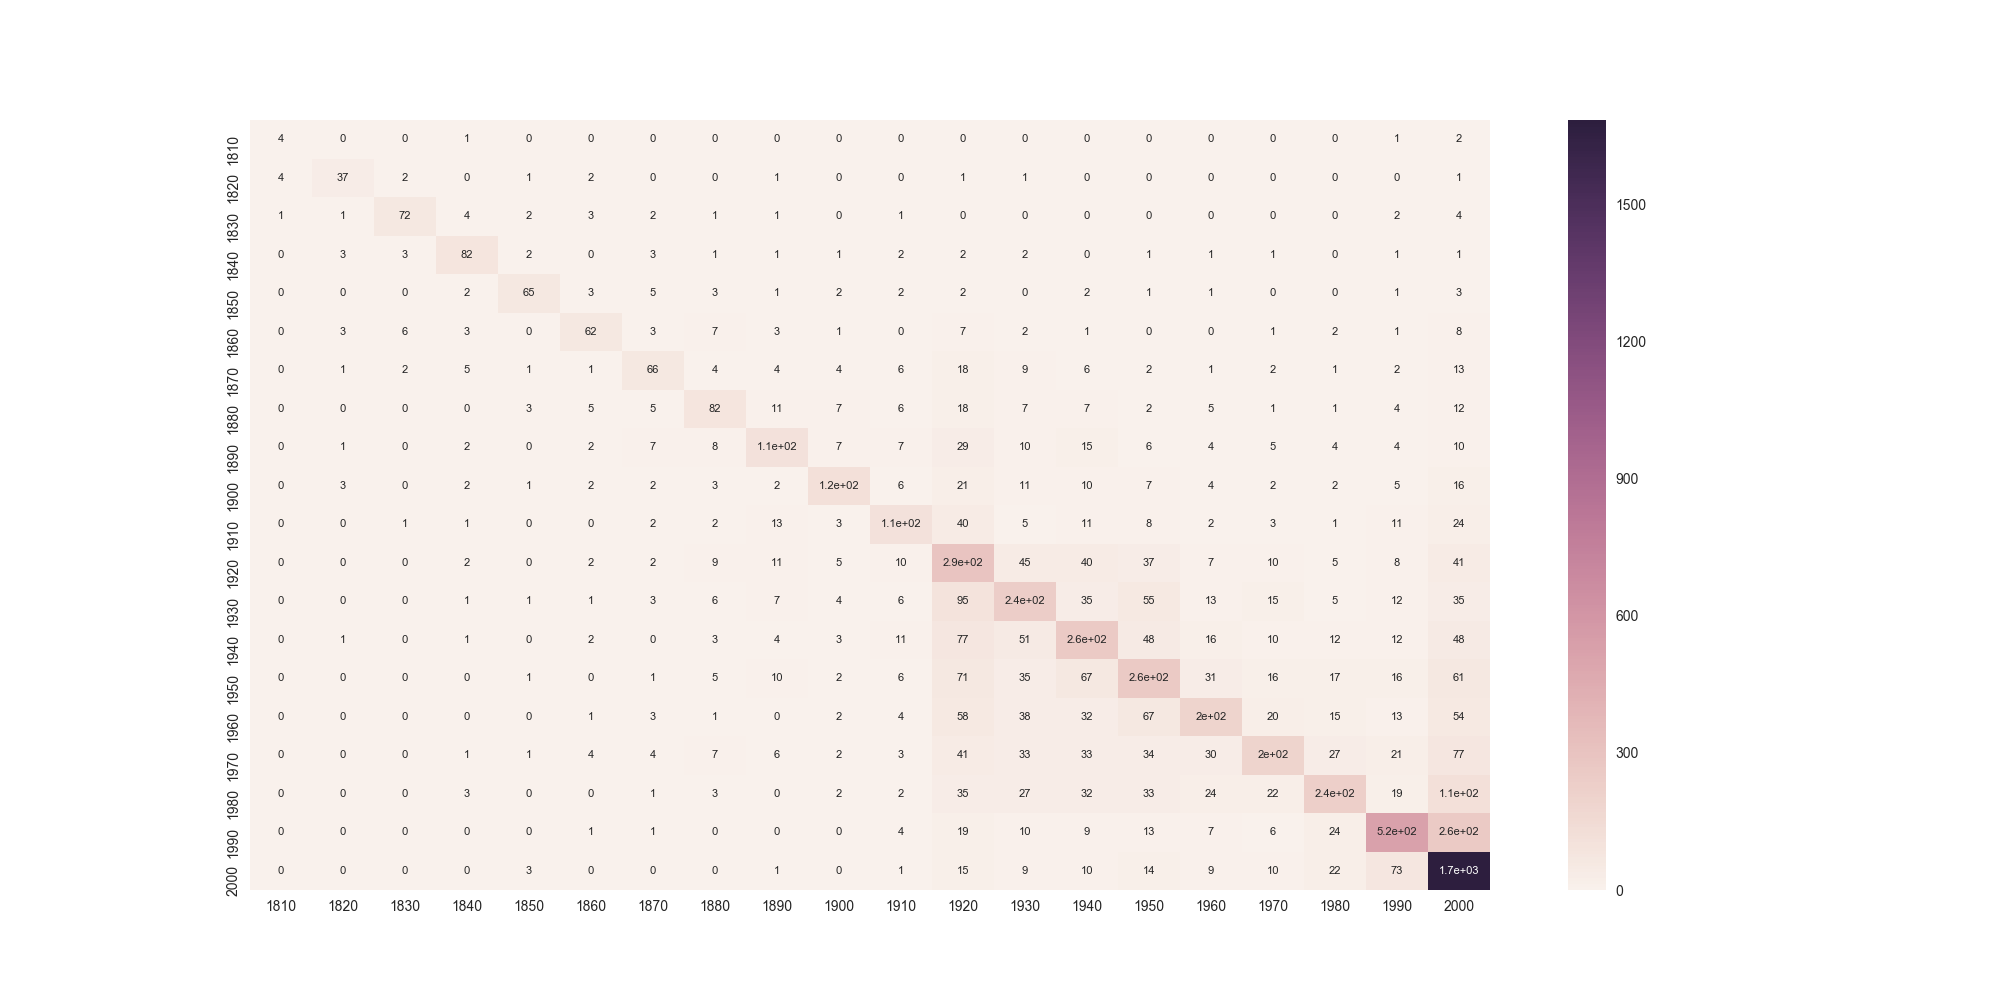

             precision    recall  f1-score   support

       1810       0.44      0.50      0.47         8
       1820       0.74      0.74      0.74        50
       1830       0.84      0.77      0.80        94
       1840       0.75      0.77      0.76       107
       1850       0.80      0.70      0.75        93
       1860       0.68      0.56      0.62       110
       1870       0.60      0.45      0.51       148
       1880       0.57      0.47      0.51       176
       1890       0.59      0.48      0.53       231
       1900       0.72      0.54      0.62       216
       1910       0.59      0.47      0.52       238
       1920       0.35      0.55      0.43       525
       1930       0.45      0.45      0.45       534
       1940       0.45      0.46      0.46       556
       1950       0.45      0.44      0.44       603
       1960       0.56      0.39      0.46       504
       1970       0.62      0.39      0.48       527
       1980       0.63      0.43      0.51   

In [29]:
eval_learner(coha_test['Decade'], RF_pred)

### SVM

In [16]:
SVM_clf = LinearSVC(random_state=0).fit(X_train, coha_train['Decade'])

In [17]:
SVM_pred = SVM_clf.predict(X_test)

<IPython.core.display.Javascript object>


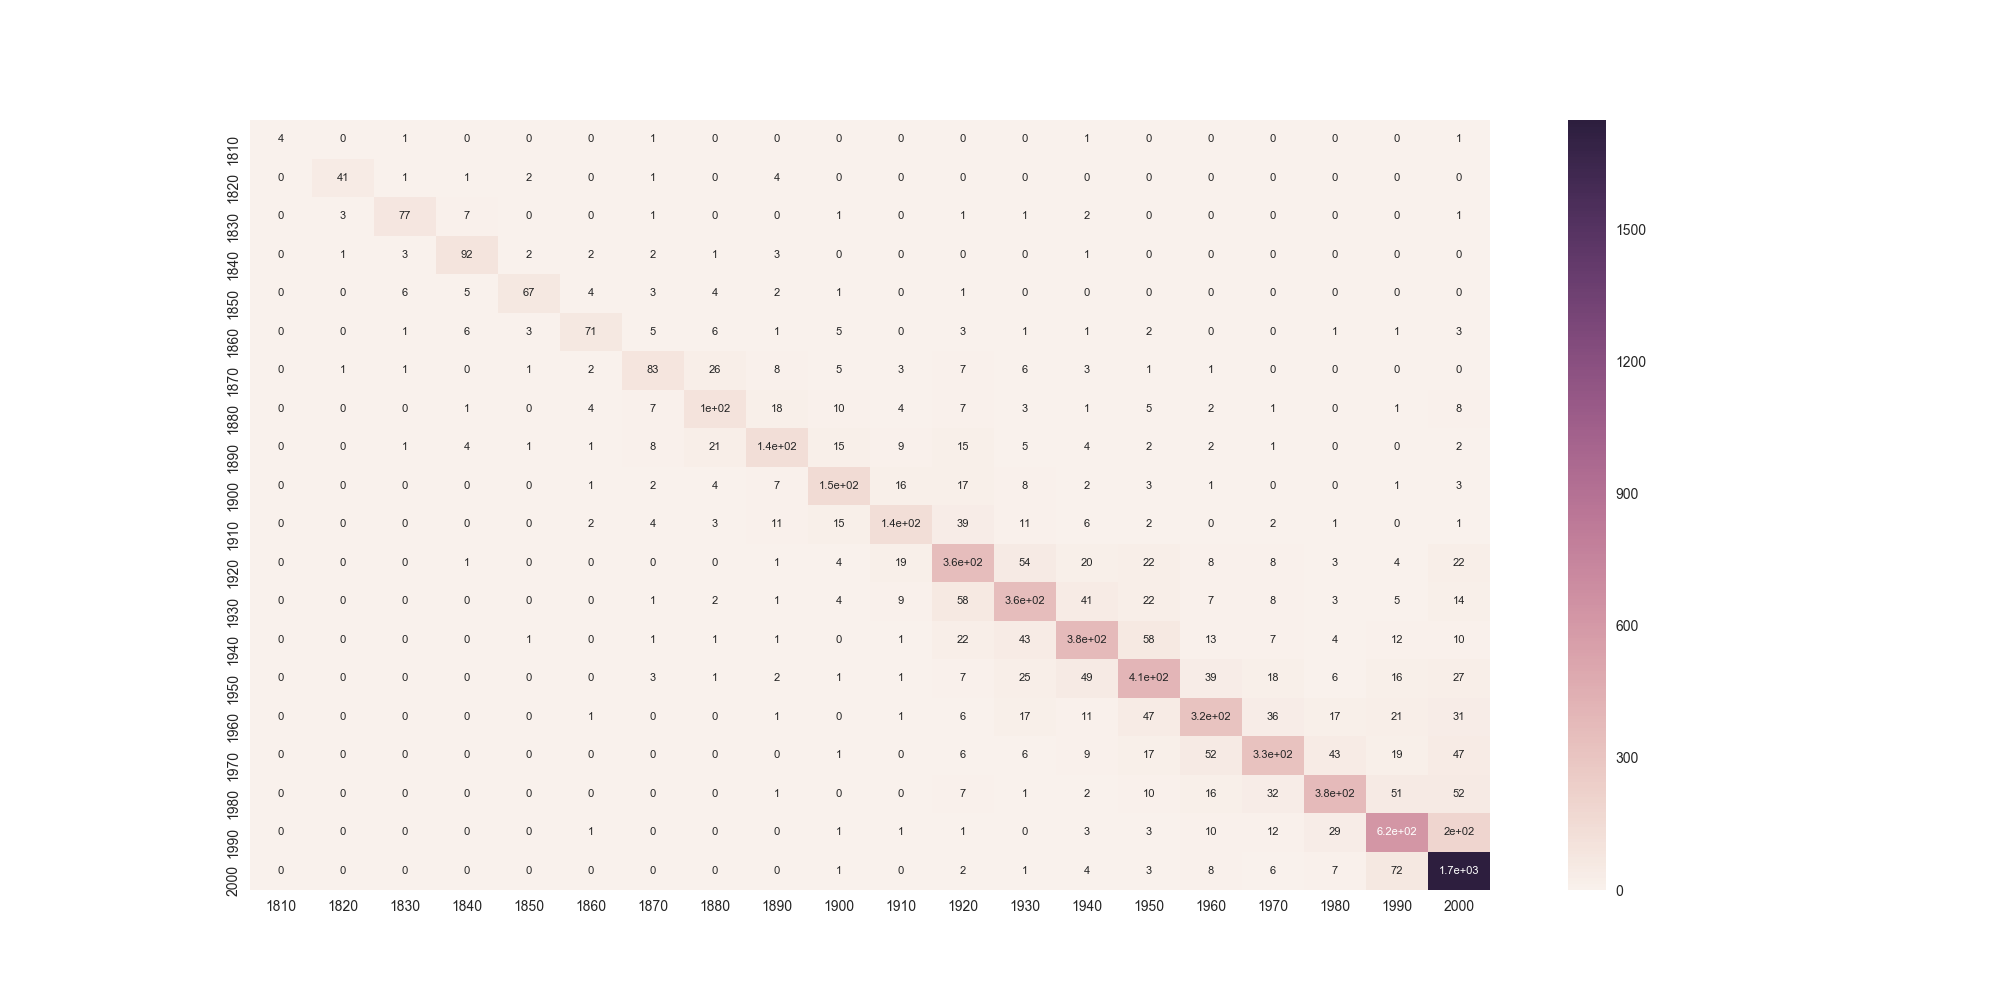

             precision    recall  f1-score   support

       1810       1.00      0.50      0.67         8
       1820       0.89      0.82      0.85        50
       1830       0.85      0.82      0.83        94
       1840       0.79      0.86      0.82       107
       1850       0.87      0.72      0.79        93
       1860       0.80      0.65      0.71       110
       1870       0.68      0.56      0.61       148
       1880       0.60      0.59      0.60       176
       1890       0.70      0.61      0.65       231
       1900       0.70      0.70      0.70       216
       1910       0.69      0.59      0.64       238
       1920       0.64      0.68      0.66       525
       1930       0.66      0.67      0.67       534
       1940       0.70      0.69      0.70       556
       1950       0.67      0.68      0.68       603
       1960       0.66      0.62      0.64       504
       1970       0.71      0.62      0.66       527
       1980       0.77      0.69      0.73   

In [18]:
eval_learner(coha_test['Decade'], SVM_pred)

#### Trigram

In [39]:
SVM_ngclf = LinearSVC(random_state=0).fit(X_train_ng, coha_train['Decade'])

In [40]:
SVM_ngpred = SVM_ngclf.predict(X_test_ng)

<IPython.core.display.Javascript object>


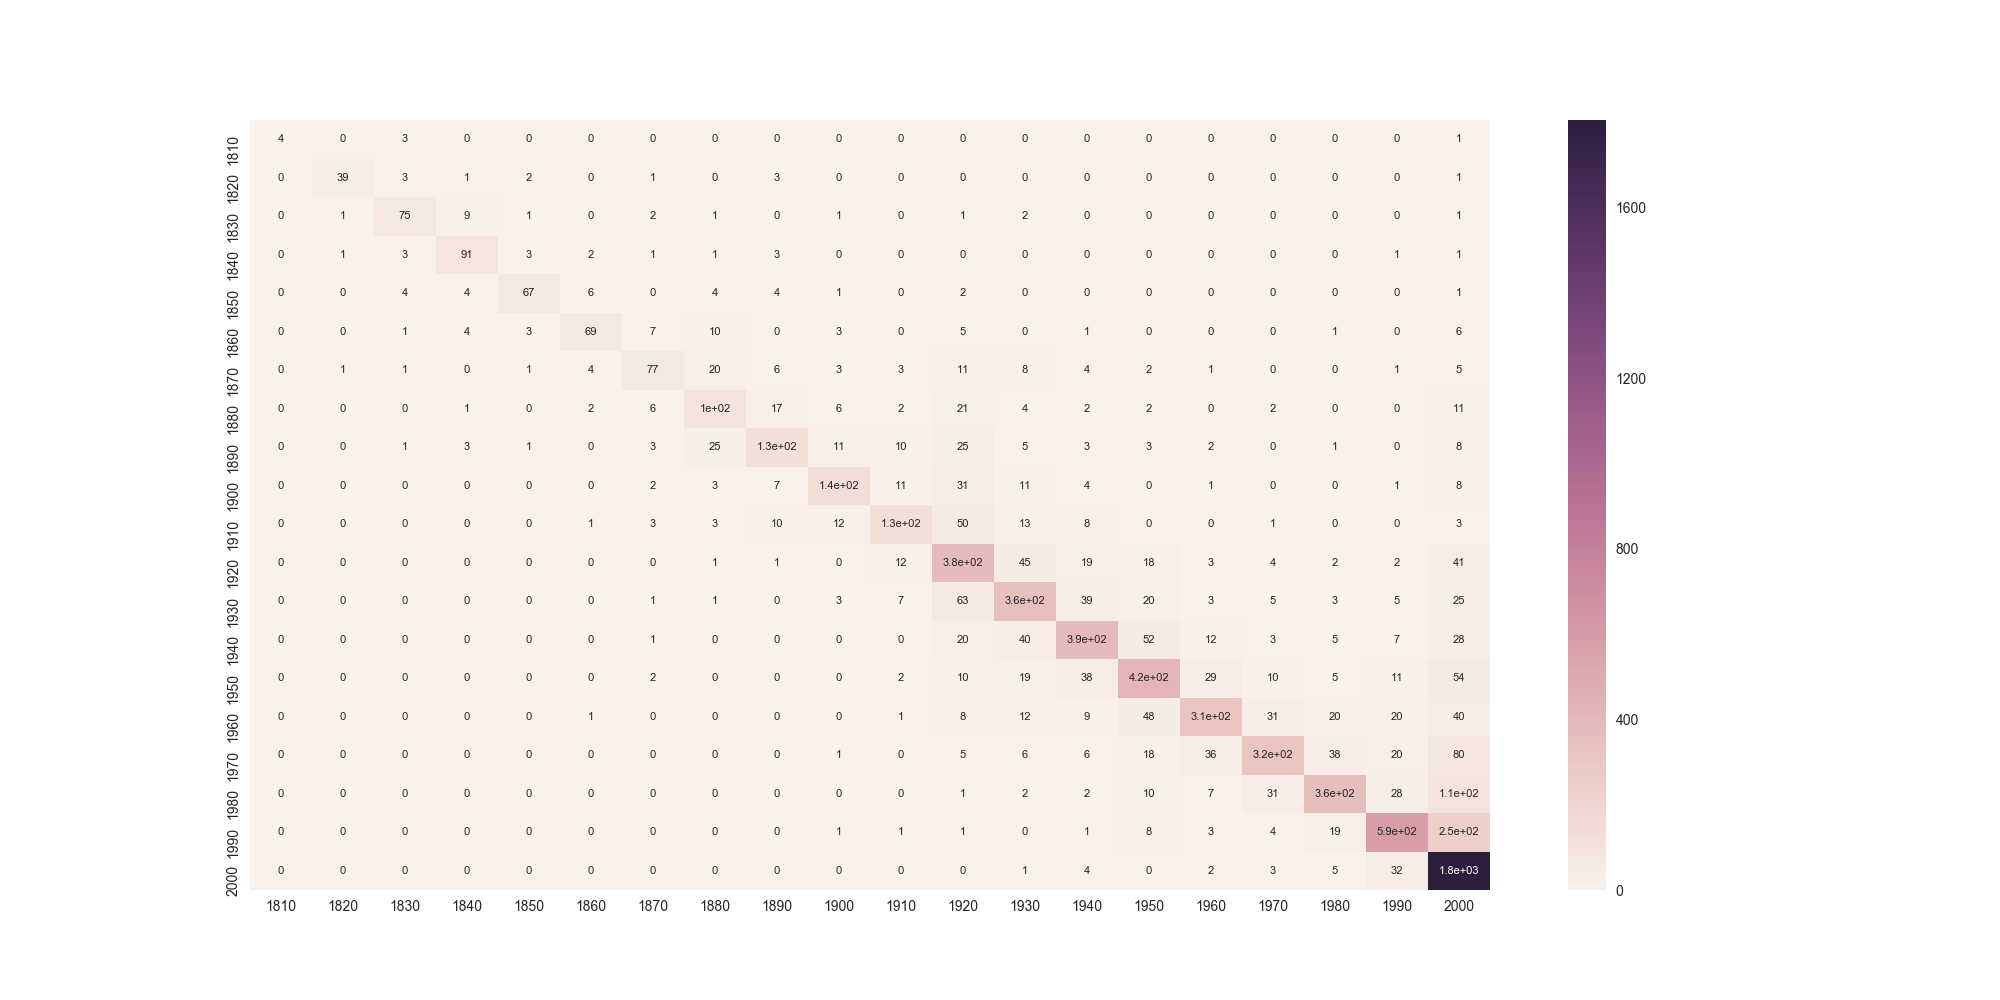

             precision    recall  f1-score   support

       1810       1.00      0.50      0.67         8
       1820       0.93      0.78      0.85        50
       1830       0.82      0.80      0.81        94
       1840       0.81      0.85      0.83       107
       1850       0.86      0.72      0.78        93
       1860       0.81      0.63      0.71       110
       1870       0.73      0.52      0.61       148
       1880       0.59      0.57      0.58       176
       1890       0.72      0.56      0.63       231
       1900       0.77      0.63      0.69       216
       1910       0.73      0.56      0.64       238
       1920       0.60      0.72      0.65       525
       1930       0.68      0.67      0.68       534
       1940       0.73      0.70      0.72       556
       1950       0.70      0.70      0.70       603
       1960       0.76      0.62      0.68       504
       1970       0.77      0.60      0.68       527
       1980       0.78      0.65      0.71   

In [41]:
eval_learner(coha_test['Decade'], SVM_ngpred)

# Refined Models

Given the preliminary results obtained earlier we now extend our implementations to include more practical model tuning.

To aid in our understanding of the problem space and the behavior of our models, it will be beneficial to plot the learning curves.  For convenience we will use the implementation of a learning curve plot generator from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py.

In [7]:
def plot_learning_curve(title, model, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Improving SVM

As SVM was the best performing model in the first experiment, we will examine how close to optimal it was in the original COHA space.

First we will use grid search to find optimal parameters for SVM.

In [5]:
SVM_clf = GridSearchCV(LinearSVC(random_state=0), 
                      {'C': [.001, .01, .1, 1, 1.001, 1.01, 1.1, 1.15, 1.2, 1.5]}, 
                       scoring='neg_mean_absolute_error', 
                       n_jobs=1)
SVM_clf.fit(X_train, coha_train['Decade'])

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 1.001, 1.01, 1.1, 1.15, 1.2, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [8]:
print SVM_clf.best_estimator_

LinearSVC(C=1.15, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)


<IPython.core.display.Javascript object>


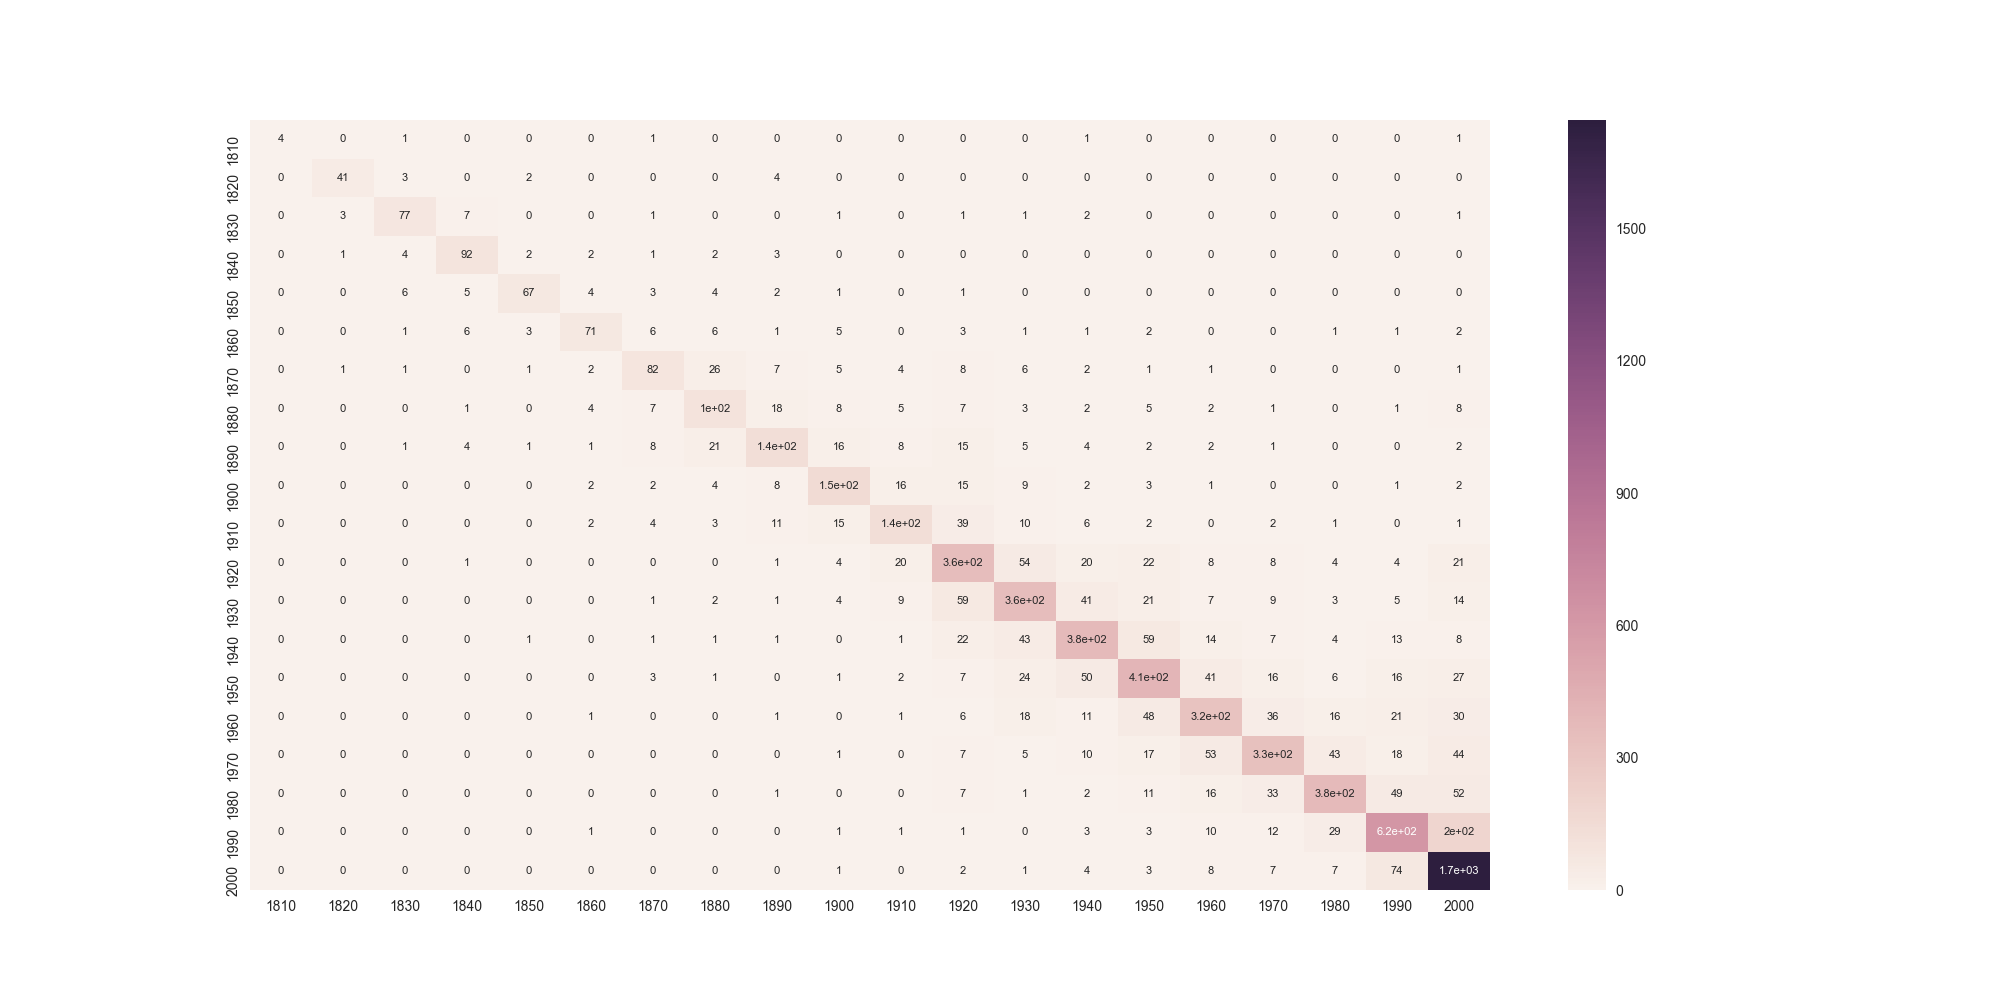

             precision    recall  f1-score   support

       1810       1.00      0.50      0.67         8
       1820       0.89      0.82      0.85        50
       1830       0.82      0.82      0.82        94
       1840       0.79      0.86      0.83       107
       1850       0.87      0.72      0.79        93
       1860       0.79      0.65      0.71       110
       1870       0.68      0.55      0.61       148
       1880       0.60      0.59      0.59       176
       1890       0.70      0.61      0.65       231
       1900       0.71      0.70      0.70       216
       1910       0.68      0.60      0.64       238
       1920       0.64      0.68      0.66       525
       1930       0.66      0.67      0.67       534
       1940       0.70      0.69      0.69       556
       1950       0.67      0.68      0.68       603
       1960       0.66      0.62      0.64       504
       1970       0.71      0.62      0.67       527
       1980       0.77      0.69      0.73   

In [9]:
SVM_pred = SVM_clf.predict(X_test)
eval_learner(coha_test['Decade'], SVM_pred)

Next let's plot the learning curve for SVM with the optimal hyperparameters.

<IPython.core.display.Javascript object>


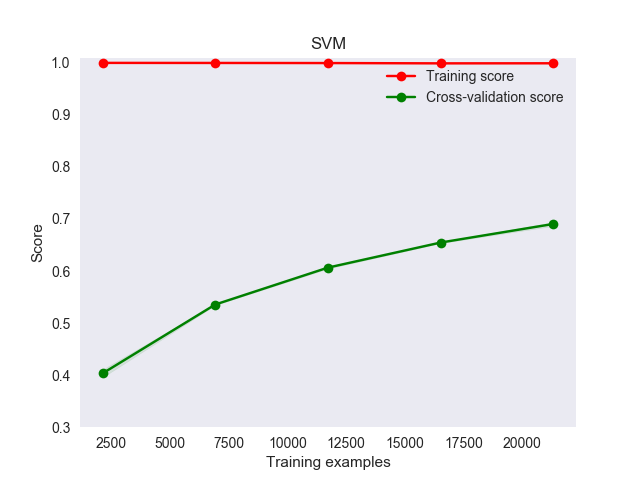

<module 'matplotlib.pyplot' from '/Users/heatherfrantz/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [12]:
plot_learning_curve('SVM', LinearSVC(C=1.15, random_state=0), X_train, coha_train['Decade'], (0.3, 1.01))

From this plot we see that our model may be able to generalize better given more data.  Having this in mind we will incorporate the New York Times dataset for training/test.

## Incorporating Other Corpora

We need to incorporate the NYT dataset which was aquired through the public API.  The data consists of snippets and leading paragraphs from news articles from 1850's-2000's.

### New York Times

First we need to define our parsing interface.  It is similar to the parse_COHA method defined earlier, however we will now return the data as a list instead of as a DataFrame.

In [8]:
def parse_NYT(filename):
    data = []
    year = filename[:4]
    decade = int(filename[:3] + '0')
    
    with open('Data/New York Times/' + filename, 'r') as f:
        samples = f.read().split('\n')[:-1]  # Ignore final newline
    
    # Ignore short snippets
    for sample in samples:
        if len(sample.split(' ')) > 10:
            data.append((year, sample, decade, len(sample)))
    
    return data

Next we will parse our data records from the years 1851-2002.

In [9]:
NYT_data = []

for year in range(1851, 2003):
    NYT_data = NYT_data + parse_NYT(str(year) + '.txt')

Now we can store our data into a DataFrame.

In [10]:
NYT_data = pd.DataFrame(NYT_data, columns=['Year', 'Text', 'Decade', 'Length'])

We will do some exploratory analysis of the NYT dataset to see how best to incorporate the data into COHA without polluting the frequency balance.

Year Coverage Statistics:
    Max: 2210
    Min: 518
    Mean: 1409.32894737
    Std: 374.999510398
    Median: 1461.0

Complete Year Distribution:
1851    1056
1852     914
1853    1139
1854    1094
1855    1156
1856    1109
1857    1289
1858    1219
1859    1221
1860     924
1861     978
1862     984
1863    1106
1864     887
1865    1088
1866    1316
1867    1301
1868    1301
1869    1426
1870    1543
1871     983
1872     883
1873     770
1874     518
1875     710
1876    1066
1877     869
1878     820
1879     654
1880     805
1881     856
1882    1357
1883    1083
1884    1757
1885    1790
1886    1838
1887    1842
1888    1795
1889    1790
1890     715
1891     885
1892     767
1893    1467
1894    1516
1895     888
1896    1018
1897     869
1898     806
1899     795
1900     805
1901     829
1902     717
1903     740
1904     875
1905     926
1906    1153
1907    1401
1908    1486
1909    1679
1910    1455
1911    1666
1912    1714
1913    1239
1914    1426
1915    1349
1916   

<IPython.core.display.Javascript object>


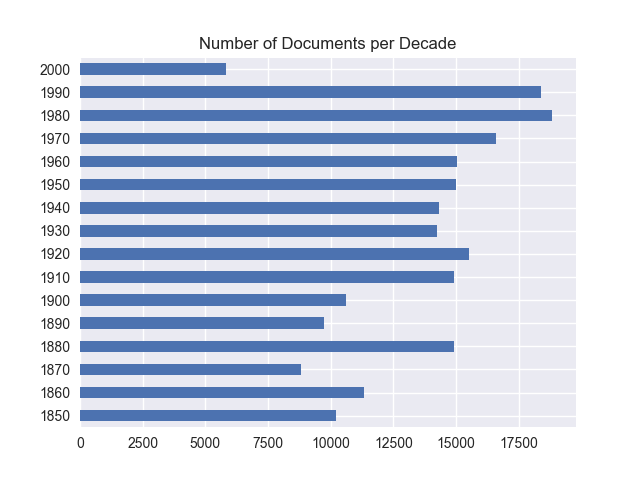

In [11]:
analyze_corpus_data(NYT_data)

We see from the above analysis that the number of documents is relatively balanced between all decade classes.  This is a pleasant surprise.

Text Frequency Statistics:

Total:
Decade
1850    2419901
1860    2443740
1870    1858647
1880    3106553
1890    2052441
1900    2182818
1910    2670512
1920    2713066
1930    2671475
1940    2554671
1950    2523790
1960    3109166
1970    6467174
1980    4536864
1990    5293286
2000    2142887
Name: Length, dtype: int64

Max:
Decade
1850     247
1860    1054
1870     247
1880     247
1890     255
1900     398
1910     870
1920     624
1930     699
1940     654
1950     897
1960    1307
1970    3079
1980    1496
1990    1763
2000    1866
Name: Length, dtype: int64

Min:
Decade
1850    53
1860    44
1870    49
1880    50
1890    49
1900    37
1910    44
1920    38
1930    41
1940    35
1950    42
1960    45
1970    50
1980    29
1990    19
2000    65
Name: Length, dtype: int64

Mean:
Decade
1850    237.314995
1860    216.049863
1870    210.826565
1880    208.311741
1890    211.026218
1900    205.712751
1910    179.108786
1920    174.788429
1930    187.616757
1940    178.585879
1950   

<IPython.core.display.Javascript object>


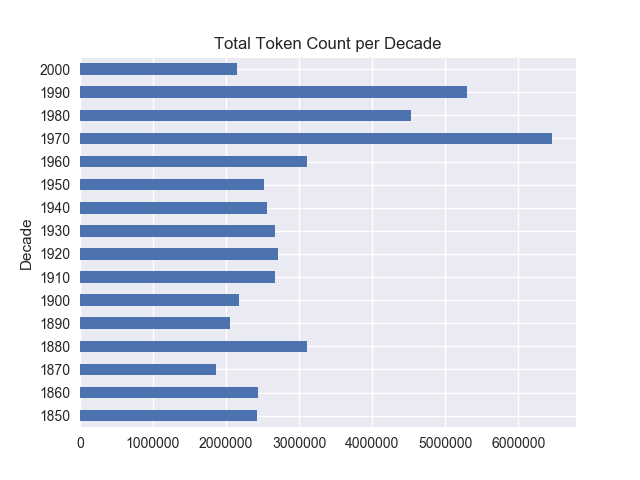

In [12]:
analyze_text(NYT_data)

We see that the word frequency is also relatively balanced amoung all decades except for 1970-1990 which has longer documents than the rest.

Next let us combine COHA and NYT to see the total data statistics.

In [13]:
coha_full['Corpus'] = 'COHA'
NYT_data['Corpus'] = 'NYT'

In [14]:
coha_NYT_data = pd.concat([coha_full, NYT_data])

As usual let's save our dataset for future use.

In [15]:
coha_NYT_data.to_pickle('coha_NYT.pkl')

In [ ]:
coha_NYT_data = pd.read_pickle('coha_NYT.pkl')

We can now analyze the year/decade coverage statistics.

Year Coverage Statistics:
    Max: 2812
    Min: 1
    Mean: 1271.09
    Std: 765.215896818
    Median: 1481.0

Complete Year Distribution:
1810       2
1811       4
1812       6
1813       1
1814       3
1815      11
1816       8
1817       9
1818       5
1819       7
1820      14
1821      20
1822      21
1823      21
1824      16
1825      13
1826      16
1827      39
1828      27
1829      37
1830      40
1831      25
1832      44
1833      55
1834      50
1835      67
1836      63
1837      44
1838      39
1839      60
1840      30
1841      30
1842      34
1843      45
1844      76
1845      69
1846      45
1847      58
1848      52
1849      65
1850      40
1851    1097
1852     958
1853    1194
1854    1137
1855    1217
1856    1154
1857    1324
1858    1237
1859    1269
1860     954
1861    1023
1862    1040
1863    1160
1864     977
1865    1137
1866    1363
1867    1342
1868    1377
1869    1494
1870    1582
1871    1058
1872     942
1873     846
1874     607
1875     804
18

<IPython.core.display.Javascript object>


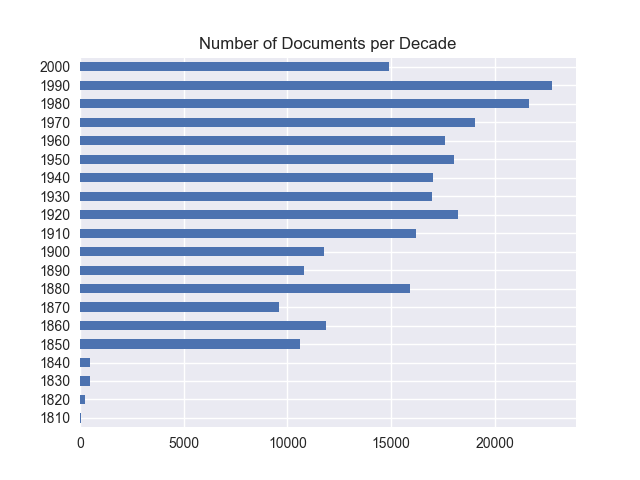

In [16]:
analyze_corpus_data(coha_NYT_data)

Next we will visualize the text frequency per decade.

Text Frequency Statistics:

Total:
Decade
1810     2866316
1820     9496850
1830    21853319
1840    23512631
1850    26796073
1860    22061228
1870    26111649
1880    28526043
1890    26669615
1900    28545529
1910    30923605
1920    28710920
1930    29408629
1940    28445120
1950    29585796
1960    28474381
1970    32678419
1980    34801546
1990    35052118
2000    32601880
Name: Length, dtype: int64

Max:
Decade
1810    227155
1820    160380
1830    252998
1840    364780
1850    251887
1860    255796
1870    213229
1880    191478
1890    200410
1900    240932
1910    210337
1920    213193
1930    245479
1940    213128
1950    207824
1960    176500
1970    302613
1980    294180
1990    141824
2000     60408
Name: Length, dtype: int64

Min:
Decade
1810    216
1820    197
1830    180
1840      1
1850      0
1860     44
1870      1
1880     50
1890     49
1900     37
1910     44
1920     38
1930     41
1940     33
1950     42
1960     45
1970     28
1980     14
1990      7
2000      

<IPython.core.display.Javascript object>


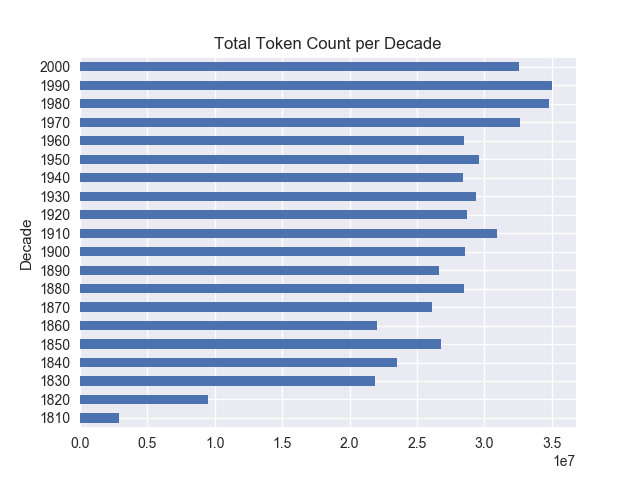

In [17]:
analyze_text(coha_NYT_data)

We can see that the COHA + NYT data is fairly imbalanced.  In any case, it will be interesting to train an SVM on this new dataset and see how the performance compares to before.

### COHA + NYT SVM

First we will do an 80/20 train/test split.

In [18]:
coha_NYT_train, coha_NYT_test = train_test_split(coha_NYT_data, test_size=0.2)
coha_NYT_train.to_pickle('coha_NYT_train.pkl')
coha_NYT_test.to_pickle('coha_NYT_test.pkl')

In [3]:
coha_NYT_train = pd.read_pickle('coha_NYT_train.pkl')
coha_NYT_test = pd.read_pickle('coha_NYT_test.pkl')

Next we need to extract our features.

In [10]:
vectorizer = CountVectorizer(stop_words='english')
transformer = TfidfTransformer()
X_train_counts = vectorizer.fit_transform(coha_NYT_train['Text'])
X_train = transformer.fit_transform(X_train_counts)

In [20]:
X_test_counts = vectorizer.transform(coha_NYT_test['Text'])
X_test = transformer.transform(X_test_counts)

Save the features for later use.

In [32]:
pickle.dump(X_train, open("coha_NYT_BoW_train.pkl", "wb"))
pickle.dump(X_test, open("coha_NYT_BoW_test.pkl", "wb"))

In [2]:
X_train = pickle.load(open("coha_NYT_BoW_train.pkl", "rb"))
X_test = pickle.load(open("coha_NYT_BoW_test.pkl", "rb"))

Now we can plot the learning curve for SVM to see what impact our additional data had on the model

<IPython.core.display.Javascript object>


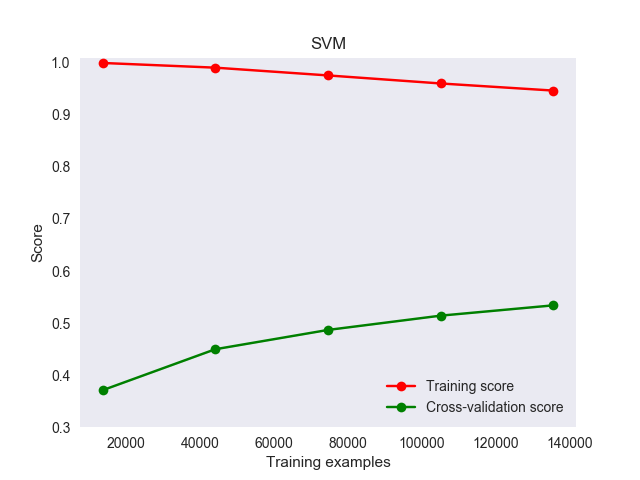

<module 'matplotlib.pyplot' from '/Users/heatherfrantz/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [22]:
plot_learning_curve('SVM', LinearSVC(C=1.15, random_state=0), X_train, coha_NYT_train['Decade'], (0.3, 1.01))

We see that by incorporating the NYT data the problem has become much harder to model.  Let's try hyperparameter tuning to get better results.

In [29]:
SVM_clf = GridSearchCV(LinearSVC(random_state=0), 
                      {'C': [.2, .35, .5, .65, .8, .95]}, 
                       scoring='neg_mean_absolute_error', 
                       n_jobs=1)
SVM_clf.fit(X_train, coha_NYT_train['Decade'])

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.2, 0.35, 0.5, 0.65, 0.8, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [30]:
print SVM_clf.best_estimator_

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)


<IPython.core.display.Javascript object>


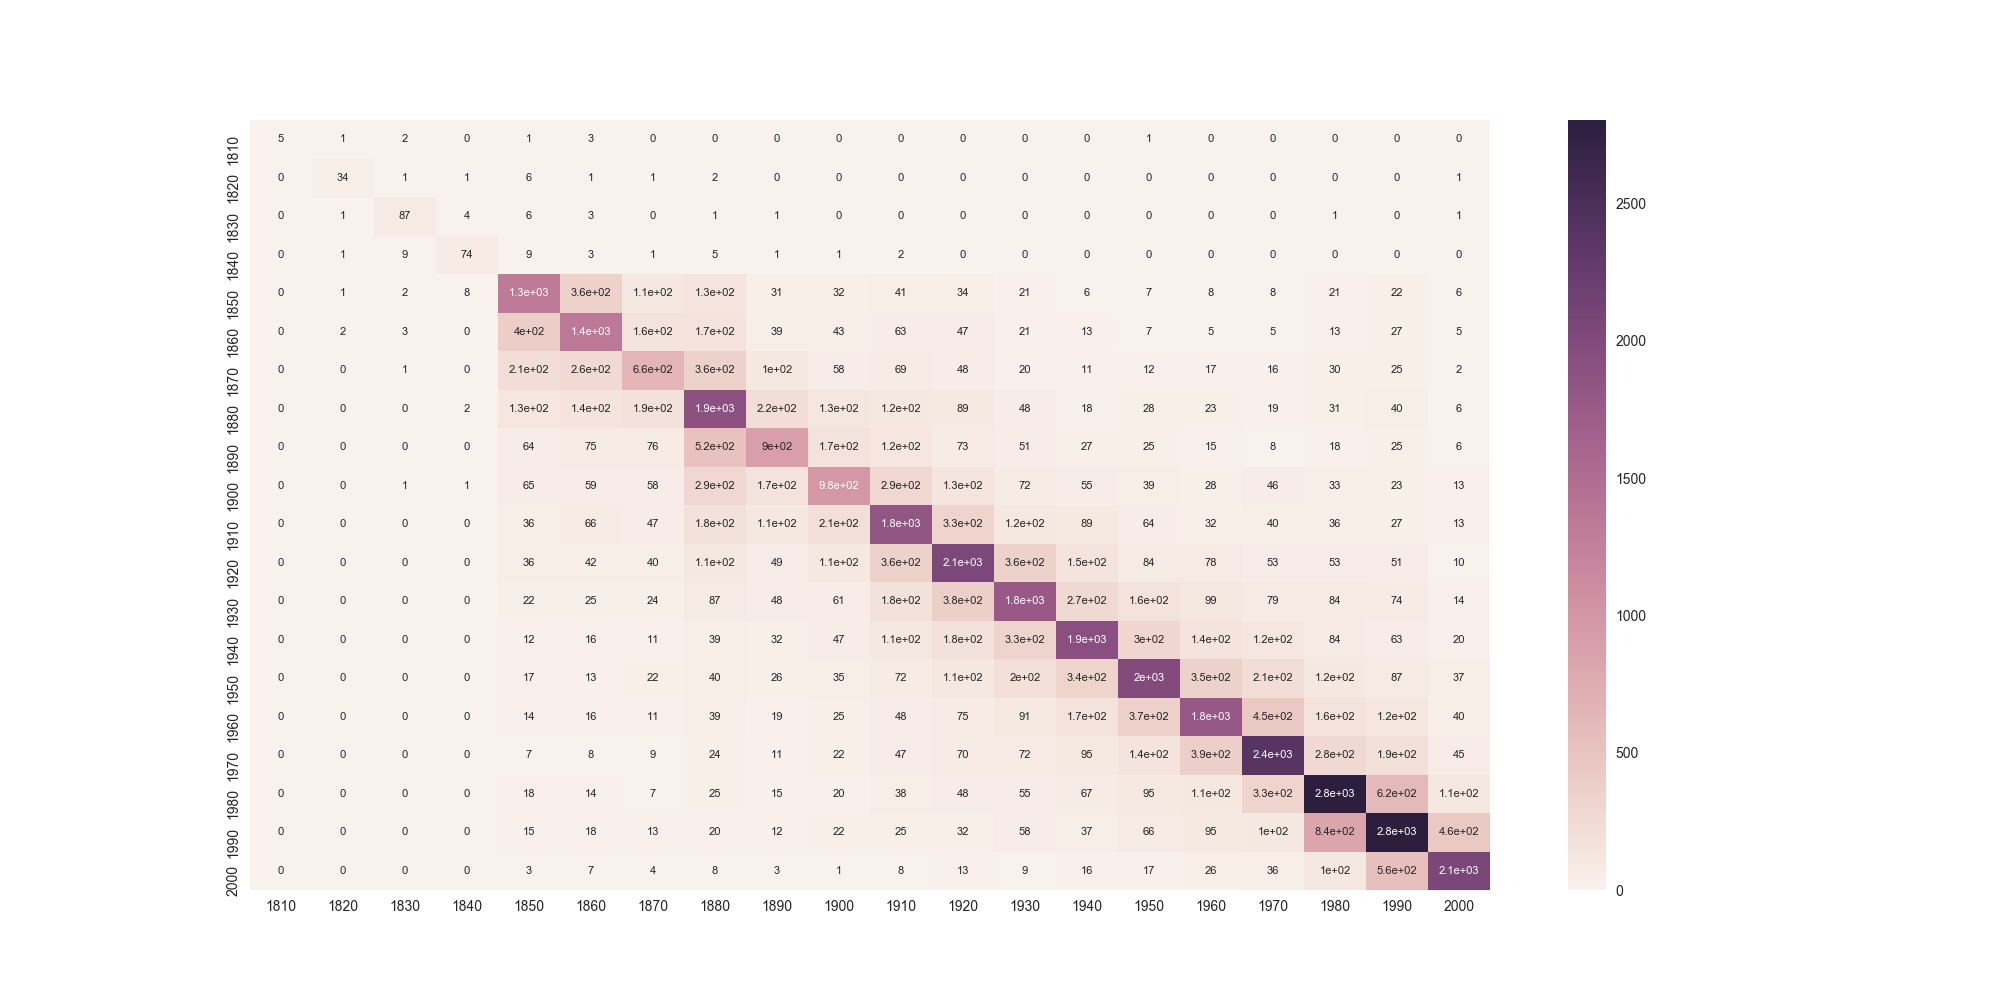

             precision    recall  f1-score   support

       1810       1.00      0.38      0.56        13
       1820       0.85      0.72      0.78        47
       1830       0.82      0.83      0.82       105
       1840       0.82      0.70      0.76       106
       1850       0.55      0.61      0.58      2164
       1860       0.55      0.57      0.56      2378
       1870       0.46      0.35      0.40      1899
       1880       0.48      0.61      0.54      3139
       1890       0.50      0.41      0.45      2175
       1900       0.50      0.42      0.45      2360
       1910       0.54      0.57      0.55      3227
       1920       0.55      0.56      0.56      3636
       1930       0.54      0.52      0.53      3378
       1940       0.59      0.56      0.57      3422
       1950       0.59      0.55      0.56      3675
       1960       0.56      0.52      0.54      3456
       1970       0.61      0.63      0.62      3808
       1980       0.60      0.64      0.62   

In [8]:
SVM_clf = LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)
SVM_clf.fit(X_train, coha_NYT_train['Decade'])
SVM_pred = SVM_clf.predict(X_test)
eval_learner(coha_NYT_test['Decade'], SVM_pred)

## Comparison with Previous Paper

To gain an "apples to apples" comparison of our methods we will need to save the test set in a parsable format for the RNN architecture.

In [12]:
coha_test = coha_NYT_test.loc[coha_NYT_test['Corpus'] == 'COHA']
NYT_test = coha_NYT_test.loc[coha_NYT_test['Corpus'] == 'NYT']

In [25]:
with open('coha_test.data', 'a') as f:
    for i in range(0, len(coha_test)):
        f.write(str(coha_test.iloc[i]['Year']) + '\t' + coha_test.iloc[i]['Text'] + '\n')
        
with open('nyt_test.data', 'a') as f:
    for i in range(0, len(NYT_test)):
        f.write(str(NYT_test.iloc[i]['Year']) + '\t' + NYT_test.iloc[i]['Text'] + '\n')

### Results from Previous Paper

dataset, method, mean_abs_error, median_abs_error, mean_accuracy, pw_score, mean_abs_error_dec, median_abs_error_dec, mean_accuracy_dec

score('NYTimes', '0.03-v1-rep-1', 25.11502255344185, 18.0, 0.01789566581682683, 0.16109821924484702, 25.177240635418709, 20.0, 0.15941851343400668)

score('COHA_100', '0.03-v1-rep-1', 25.861715933669792, 15.0, 0.025955299206921412, 0.20184679649518691, 25.945205479452056, 20.0, 0.19855803893294882)

score('COHA_500', '0.03-v1-rep-1', 21.984859408795963, 13.0, 0.031002162941600575, 0.23847609808407552, 22.298485940879598, 10.0, 0.23114635904830569)

score('COHA_1000', '0.03-v1-rep-1', 21.376928622927181, 13.0, 0.032299927901946648, 0.24076844977761547, 21.770728190338861, 10.0, 0.23028118240807499)

score('COHA_2000', '0.03-v1-rep-1', 20.978658976207644, 13.0, 0.034174477289113193, 0.24111475875694943, 21.352559480894016, 10.0, 0.22826243691420331)

Displaying the relevant information as a table:

<IPython.core.display.Javascript object>


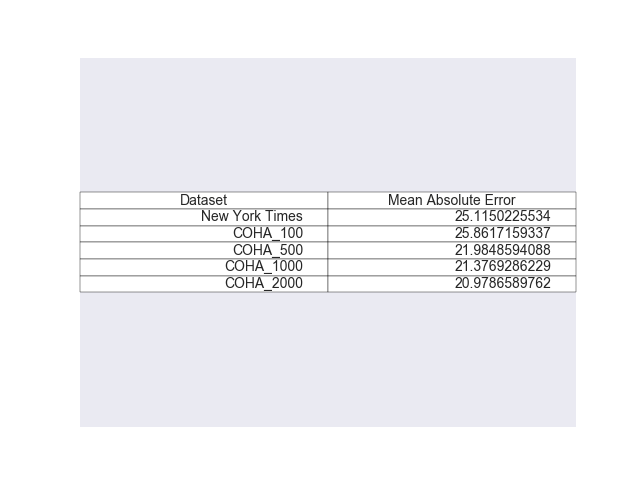

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
colLabels = ('Dataset', 'Mean Absolute Error')
RNNResults = (['New York Times', 25.11502255344185],
              ['COHA_100', 25.861715933669792],
              ['COHA_500', 21.984859408795963],
              ['COHA_1000', 21.376928622927181],
              ['COHA_2000', 20.978658976207644])
table = ax.table(cellText=RNNResults, colLabels=colLabels, loc='center')
plt.show()

### SVM Results

Next we need to compare the SVM using the same test set partitioning scheme.

In [13]:
NYT_test_features = transformer.transform(vectorizer.transform(NYT_test['Text']))
SVM_pred = SVM_clf.predict(NYT_test_features)
print 'MAE: ' + str(mean_absolute_error(NYT_test['Decade'], SVM_pred))
print 'Accuracy: ' + str(accuracy_score(NYT_test['Decade'], SVM_pred))

MAE: 11.9183673469
Accuracy: 0.540408163265


To mimic the length based experiements we will need to implement a function which matches the conventions used in the previous work exactly.

In [14]:
def get_First_K_Words(text, k):
    split = text.split(' ')[100:]  # Skip the first 100 words, as in the paper...
    return ' '.join(split[:k])     # Return the first k words

In [15]:
coha_100 = [get_First_K_Words(text, 100) for text in coha_test['Text'].values.tolist()]

In [18]:
coha_100_test_features = transformer.transform(vectorizer.transform(coha_100))
SVM_pred = SVM_clf.predict(coha_100_test_features)
print 'MAE: ' + str(mean_absolute_error(coha_test['Decade'], SVM_pred))
print 'Accuracy: ' + str(accuracy_score(coha_test['Decade'], SVM_pred))

MAE: 25.1788179194
Accuracy: 0.334922825951


In [19]:
coha_500 = [get_First_K_Words(text, 500) for text in coha_test['Text'].values.tolist()]

In [20]:
coha_500_test_features = transformer.transform(vectorizer.transform(coha_500))
SVM_pred = SVM_clf.predict(coha_500_test_features)
print 'MAE: ' + str(mean_absolute_error(coha_test['Decade'], SVM_pred))
print 'Accuracy: ' + str(accuracy_score(coha_test['Decade'], SVM_pred))

MAE: 14.1899861965
Accuracy: 0.525787426277


In [21]:
coha_1000 = [get_First_K_Words(text, 1000) for text in coha_test['Text'].values.tolist()]

In [22]:
coha_1000_test_features = transformer.transform(vectorizer.transform(coha_1000))
SVM_pred = SVM_clf.predict(coha_1000_test_features)
print 'MAE: ' + str(mean_absolute_error(coha_test['Decade'], SVM_pred))
print 'Accuracy: ' + str(accuracy_score(coha_test['Decade'], SVM_pred))

MAE: 11.8647258125
Accuracy: 0.575229012423


In [23]:
coha_2000 = [get_First_K_Words(text, 2000) for text in coha_test['Text'].values.tolist()]

In [24]:
coha_2000_test_features = transformer.transform(vectorizer.transform(coha_2000))
SVM_pred = SVM_clf.predict(coha_2000_test_features)
print 'MAE: ' + str(mean_absolute_error(coha_test['Decade'], SVM_pred))
print 'Accuracy: ' + str(accuracy_score(coha_test['Decade'], SVM_pred))

MAE: 10.4969255866
Accuracy: 0.609988706237


<IPython.core.display.Javascript object>


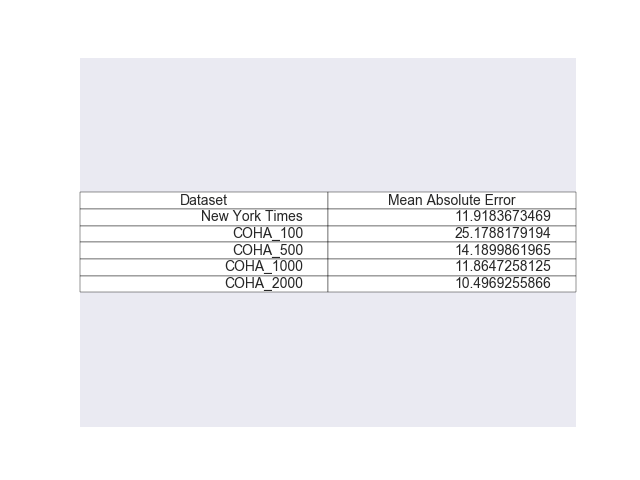

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
colLabels = ('Dataset', 'Mean Absolute Error')
Results = (['New York Times', 11.9183673469],
              ['COHA_100', 25.1788179194],
              ['COHA_500', 14.1899861965],
              ['COHA_1000', 11.8647258125],
              ['COHA_2000', 10.4969255866])
table = ax.table(cellText=Results, colLabels=colLabels, loc='center')
plt.show()

We see that in all cases except COHA_100, SVM performs significantly better than the RNN implementation.